## 🚀 Python Lab: Tesla stock price prediction using LSTM networks (PyTorch Version)
> [Principles of ML course](https://github.com/mnarimani/PML_Spring2025_SUT) - Spring 2025 - Sharif <br>
> Lab sessions - Session 9 - May 25, 2025 <br>
> Author: M Narimani <br>

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mnarimani/PML_Spring2025_SUT/blob/main/Week09/03_LSTM_TeslaStock_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mnarimani/PML_Spring2025_SUT/blob/main/Week09/03_LSTM_TeslaStock_Torch.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## 🛠️ Setup: Importing Libraries
> **TODO:** Install the required packages/libs
> - `pip install pandas_datareader` <br>
> - `pip install yfinance`
<pip install yfinance>
<pip install fix_yahoo_finance>

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Check for GPU
device = torch.device("cuda" if cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"GPU name: {cuda.get_device_name(0) if cuda.is_available() else 'No GPU'}")
print(f"Num GPUs Available: {cuda.device_count()}")

Using device: cpu


## 1️⃣ Load Historical Data

In [7]:
# Define date ranges
train_start = datetime.datetime(2019, 1, 1)
train_end = datetime.datetime(2023, 12, 30)
val_start = datetime.datetime(2024, 1, 1)
val_end = datetime.date.today()

# Fetch training and validation data using yfinance
df = yf.download("TSLA", start=train_start, end=train_end, auto_adjust=True)
val_df = yf.download("TSLA", start=val_start, end=val_end, auto_adjust=True)

# Sort by date and reset index
df = df.sort_index().reset_index().set_index("Date")
val_df = val_df.sort_index().reset_index().set_index("Date")

# Display last few rows of training data
print(df.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2023-12-22  252.539993  258.220001  251.369995  256.760010   93249800
2023-12-26  256.609985  257.970001  252.910004  254.490005   86892400
2023-12-27  261.440002  263.339996  257.519989  258.350006  106494400
2023-12-28  253.179993  265.130005  252.710007  263.660004  113619900
2023-12-29  248.479996  255.190002  247.429993  255.100006  100615300


In [8]:
# Display data shapes
print(f"Training data shape: {df.shape}")
print(f"Validation data shape: {val_df.shape}")

Training data shape: (1258, 5)
Validation data shape: (350, 5)


## 2️⃣ Data visualization

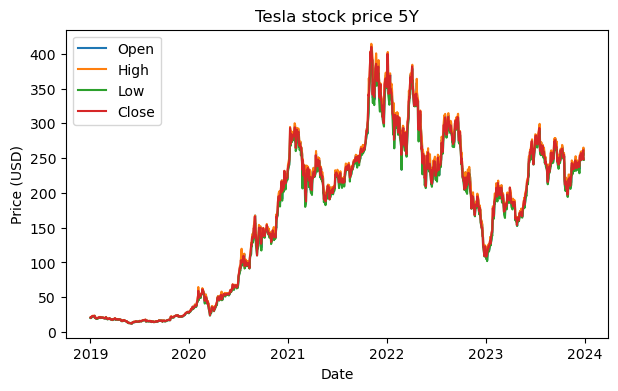

In [10]:
plt.figure(figsize = (7,4))
plt.title('Tesla stock price 5Y')
plt.plot(df.Open, label="Open")
plt.plot(df.High, label="High")
plt.plot(df.Low, label="Low")
plt.plot(df.Close, label="Close")
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
# plt.savefig('03_LSTM_OHLC.pdf', format='pdf', bbox_inches='tight')
plt.show()

> **TODO:** Plot OHLC. you may want to install libraries below:
> - `pip install https://github.com/matplotlib/mpl_finance/archive/master.zip`
> - `pip install mplfinance`
> - `pip install finplot`

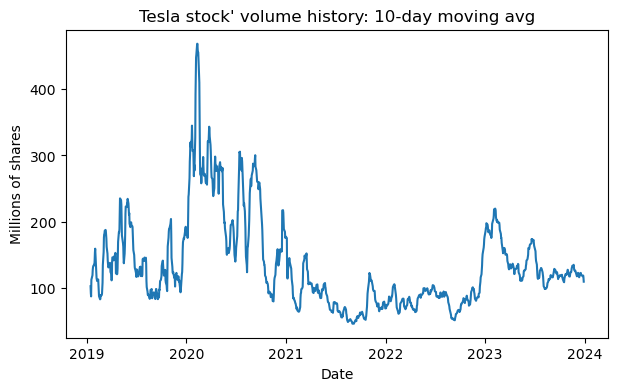

In [12]:
plt.figure(figsize = (7,4))
plt.title("Tesla stock' volume history: 10-day moving avg")
plt.plot(df.Volume.rolling(10).mean()/1e6)
plt.ylabel('Millions of shares')
plt.xlabel('Date')
plt.show()

## 3️⃣ Data Preparation
### Split training & testing data (70%-30%)

In [14]:
# Extract 'Close' price for modeling
data_target = df[['Close']].values
training_data_len = int(len(data_target) * 0.7)  # Hyperparameter: 70% for training

train_data = data_target[:training_data_len]
test_data = data_target[training_data_len:]

print(f"Training data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

Training data length: 880
Testing data length: 378


### Dataset normalization

In [16]:
# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = scaler.fit_transform(train_data)

# Apply same scaling to test data
scale_factor = scaler.scale_
data_testing_array = test_data * scale_factor

### Construct sequential training and testing data

In [18]:
# Hyperparameter: Lookback period
lookback = 100

# Training sequences
x_train, y_train = [], []
for i in range(lookback, data_training_array.shape[0]):
    x_train.append(data_training_array[i - lookback:i])
    y_train.append(data_training_array[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

# Ensure x_train is reshaped to (n_samples, lookback, 1)
x_train = x_train.reshape(-1, lookback, 1)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

# Testing sequences
x_test, y_test = [], []
for i in range(lookback, data_testing_array.shape[0]):
    x_test.append(data_testing_array[i - lookback:i])
    y_test.append(data_testing_array[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

# Ensure x_test is reshaped to (n_samples, lookback, 1)
x_test = x_test.reshape(-1, lookback, 1)

# Convert to PyTorch tensors
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Print shapes for debugging
print(f"Training x, y shape: {x_train.shape}, {y_train.shape}")
print(f"Testing x, y shape: {x_test.shape}, {y_test.shape}")

Training x, y shape: torch.Size([780, 100, 1]), torch.Size([780])
Testing x, y shape: torch.Size([278, 100, 1]), torch.Size([278])


## 4️⃣ Build LSTM Model

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, lookback=100):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 50, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(50, 60, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.lstm3 = nn.LSTM(60, 80, batch_first=True)
        self.dropout3 = nn.Dropout(0.4)
        self.lstm4 = nn.LSTM(80, 120, batch_first=True)
        self.dropout4 = nn.Dropout(0.5)
        self.fc = nn.Linear(120, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out, _ = self.lstm3(out)
        out = self.dropout3(out)
        out, _ = self.lstm4(out)
        out = self.dropout4(out)
        out = self.fc(out[:, -1, :])  # Take the last time step
        return out

# Initialize model
model = LSTMModel().to(device)

In [21]:
# Display model architecture
print(model)

LSTMModel(
  (lstm1): LSTM(1, 50, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(50, 60, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (lstm3): LSTM(60, 80, batch_first=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (lstm4): LSTM(80, 120, batch_first=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=120, out_features=1, bias=True)
)


> **TODO:** Experiment with different LSTM units and dropout rates.

## 5️⃣ Train the model

In [24]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Verify shapes match
assert x_train.shape[0] == y_train.shape[0], f"Training shape mismatch: x_train {x_train.shape[0]} vs y_train {y_train.shape[0]}"
assert x_test.shape[0] == y_test.shape[0], f"Testing shape mismatch: x_test {x_test.shape[0]} vs y_test {y_test.shape[0]}"

# Create DataLoader for training with validation split
dataset = TensorDataset(x_train, y_train)
train_size = int(0.7 * len(dataset))  # 70% for training, 30% for validation
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

# Training loop with early stopping
epochs = 50
patience = 5
best_val_loss = float('inf')
patience_counter = 0
train_losses, val_losses, train_maes, val_maes = [], [], [], []

In [25]:
%%time

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    train_mae = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
        train_mae += torch.mean(torch.abs(outputs.squeeze() - y_batch)).item() * x_batch.size(0)
    train_loss /= len(train_loader.dataset)
    train_mae /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_maes.append(train_mae)

    # Validation
    model.eval()
    val_loss = 0
    val_mae = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            val_loss += criterion(outputs.squeeze(), y_batch).item() * x_batch.size(0)
            val_mae += torch.mean(torch.abs(outputs.squeeze() - y_batch)).item() * x_batch.size(0)
    val_loss /= len(val_loader.dataset)
    val_mae /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_maes.append(val_mae)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 1/50, Train Loss: 0.0769, Val Loss: 0.0126, Train MAE: 0.2339, Val MAE: 0.0955
Epoch 2/50, Train Loss: 0.0165, Val Loss: 0.0072, Train MAE: 0.0950, Val MAE: 0.0630
Epoch 3/50, Train Loss: 0.0077, Val Loss: 0.0039, Train MAE: 0.0646, Val MAE: 0.0457
Epoch 4/50, Train Loss: 0.0085, Val Loss: 0.0036, Train MAE: 0.0656, Val MAE: 0.0428
Epoch 5/50, Train Loss: 0.0078, Val Loss: 0.0051, Train MAE: 0.0615, Val MAE: 0.0527
Epoch 6/50, Train Loss: 0.0066, Val Loss: 0.0029, Train MAE: 0.0590, Val MAE: 0.0345
Epoch 7/50, Train Loss: 0.0081, Val Loss: 0.0049, Train MAE: 0.0663, Val MAE: 0.0521
Epoch 8/50, Train Loss: 0.0060, Val Loss: 0.0027, Train MAE: 0.0553, Val MAE: 0.0371
Epoch 9/50, Train Loss: 0.0057, Val Loss: 0.0024, Train MAE: 0.0523, Val MAE: 0.0320
Epoch 10/50, Train Loss: 0.0062, Val Loss: 0.0035, Train MAE: 0.0562, Val MAE: 0.0467
Epoch 11/50, Train Loss: 0.0061, Val Loss: 0.0033, Train MAE: 0.0568, Val MAE: 0.0480
Epoch 12/50, Train Loss: 0.0054, Val Loss: 0.0024, Train MAE: 0

In [26]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test data
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test).squeeze()
    test_loss = criterion(y_test_pred, y_test).item()
    test_mae = torch.mean(torch.abs(y_test_pred - y_test)).item()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss: 0.0013
Test MAE: 0.0288


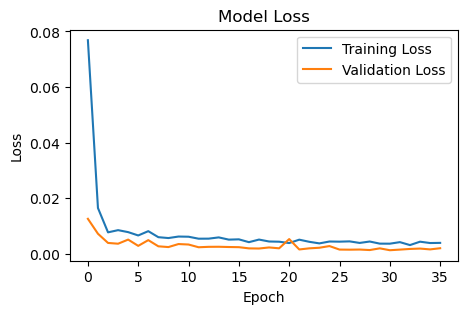

In [27]:
# Plot loss
plt.figure(figsize=(5, 3))
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
# plt.savefig('03_LSTM_loss_pytorch.pdf', format='pdf', bbox_inches='tight')
plt.show()

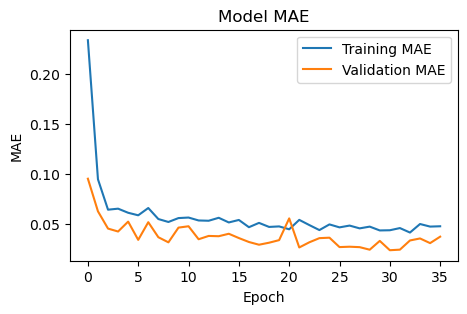

In [28]:
# Plot MAE
plt.figure(figsize=(5, 3))
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(train_maes, label='Training MAE')
plt.plot(val_maes, label='Validation MAE')
plt.legend()
# plt.savefig('03_LSTM_mae_pytorch.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 6️⃣ Make predictions

### Predict on Test Data

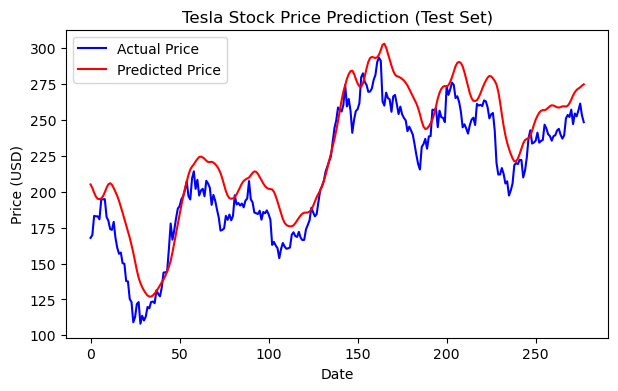

Mean Absolute Error on test set: 17.9397


In [31]:
# Predict on test data
model.eval()
with torch.no_grad():
    y_pred = model(x_test).cpu().numpy()
price_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Plot test predictions vs actual
plt.figure(figsize=(7, 4))
plt.title('Tesla Stock Price Prediction (Test Set)')
plt.plot(y_test.cpu().numpy() / scale_factor, 'b', label="Actual Price")
plt.plot(price_pred, 'r', label="Predicted Price")
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(y_test.cpu().numpy() / scale_factor, price_pred)
print(f"Mean Absolute Error on test set: {mae:.4f}")

### Predict on Validation Data

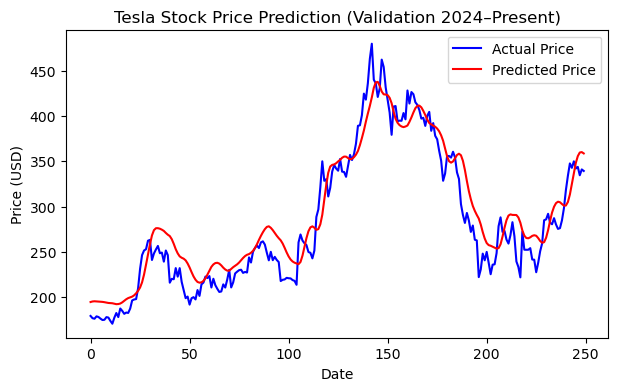

Mean Absolute Error on validation set: 19.8631


In [33]:
# Prepare validation data
val_target = val_df[['Close']].values
val_data_array = val_target * scale_factor

# Create sequences for validation
x_val, y_val = [], []
for i in range(lookback, val_data_array.shape[0]):
    x_val.append(val_data_array[i - lookback:i])
    y_val.append(val_data_array[i, 0])
x_val, y_val = np.array(x_val), np.array(y_val)

# Convert to PyTorch tensors
x_val = torch.tensor(x_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

# Predict on validation data
model.eval()
with torch.no_grad():
    y_val_pred = model(x_val).cpu().numpy()
price_val_pred = scaler.inverse_transform(y_val_pred.reshape(-1, 1))

# Plot validation predictions vs actual
plt.figure(figsize=(7, 4))
plt.title('Tesla Stock Price Prediction (Validation 2024–Present)')
plt.plot(y_val.cpu().numpy() / scale_factor, 'b', label="Actual Price")
plt.plot(price_val_pred, 'r', label="Predicted Price")
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.show()

# Calculate MAE for validation
mae_val = mean_absolute_error(y_val.cpu().numpy() / scale_factor, price_val_pred)
print(f"Mean Absolute Error on validation set: {mae_val:.4f}")

### Visualize Full Prediction Timeline

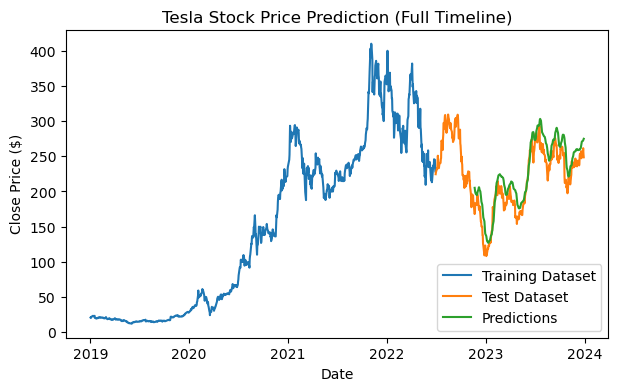

In [35]:
# Prepare data for full timeline plot
train = df[['Close']][:training_data_len]
test = df[['Close']][training_data_len:]
pred = df[['Close']][training_data_len + lookback:].copy()
pred['Predictions'] = price_pred

# Plot full timeline
plt.figure(figsize=(7, 4))
plt.title('Tesla Stock Price Prediction (Full Timeline)')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.plot(train, label='Training Dataset')
plt.plot(test, label='Test Dataset')
plt.plot(pred['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

## 7️⃣ Save the Model

In [37]:
# torch.save(model.state_dict(), 'tsla_lstm_pytorch_2019_2024.pth')